# Correlación Precio - Sentimiento
## Librerías y rutas de carga

In [15]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

DATA = Path("../data")  

eur = pd.read_csv(DATA / "EUR_USD_prices.csv").rename(
    {"1. open":"open","2. high":"high","3. low":"low","4. close":"close"}, axis=1
)
eur["date"] = pd.to_datetime(eur["date"])
eur = eur.set_index("date").sort_index()

sent = pd.read_csv(DATA / "daily_sentiment.csv")  
sent["date"] = pd.to_datetime(sent["date"])
sent = sent.set_index("date").sort_index().asfreq("D").ffill()


## Merge y features

In [16]:
df = eur.join(sent, how="inner").copy()
df["ret"] = np.log(df["close"] / df["close"].shift(1))
df["dir"] = (df["ret"] > 0).astype(int)
df["tr"] = df["high"] - df["low"]
df["vol20"] = df["ret"].rolling(20).std()

for l in [1,2,3,5]:
    df[f"sent_lag{l}"] = df["sent_mean"].shift(l)

df = df.dropna().copy()
df["target"] = df["dir"].shift(-1)
df = df.dropna().copy()
df.tail(3)


,open,high,low,close,sent_mean,ret,dir,tr,vol20,sent_lag1,sent_lag2,sent_lag3,sent_lag5,target
date,,,,,,,,,,,,,,
2025-08-05,1.1570,1.1587,1.1525,1.1574,0.000000,0.000346,1,0.0062,0.005968,0.0,0.111111,0.000000,0.0,1.0
2025-08-06,1.1571,1.1668,1.1563,1.1659,0.000000,0.007317,1,0.0105,0.006228,0.0,0.000000,0.111111,0.0,1.0
2025-08-07,1.1659,1.1698,1.1609,1.1665,-0.030303,0.000514,1,0.0089,0.006222,0.0,0.000000,0.000000,0.0,0.0


## Split temporal y modelo

In [17]:
split = int(len(df)*0.8)
train, test = df.iloc[:split], df.iloc[split:]

X_cols = ["sent_lag1","sent_lag2","sent_lag3","sent_lag5","vol20"]
X_train, y_train = train[X_cols], train["target"]
X_test,  y_test  = test[X_cols],  test["target"]

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

pred  = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, pred)
try:
    auc = roc_auc_score(y_test, proba)
except ValueError:
    auc = float("nan")

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC : {auc:.4f}")
print(classification_report(y_test, pred, digits=4))


Accuracy: 0.5625
ROC-AUC : 0.2381
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         7
         1.0     0.5625    1.0000    0.7200         9

    accuracy                         0.5625        16
   macro avg     0.2812    0.5000    0.3600        16
weighted avg     0.3164    0.5625    0.4050        16



c:\Users\apicn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\apicn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\apicn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

El modelo simple de regresión logística, basado en sentimiento diario y volatilidad, alcanza un 56% de accuracy y un ROC-AUC de 0.23. El sesgo hacia predecir únicamente la clase de subida indica que las variables actuales no aportan suficiente información para anticipar la dirección del precio. Esto revela la necesidad de: 
- Un cálculo de sentimiento más expresivo (ej. VADER, FinBERT). 
- Un dataset más amplio en el tiempo.
- Enriquecer con features adicionales como retornos rezagados, indicadores técnicos o volumen.

## Plots de sentimiento vs precio

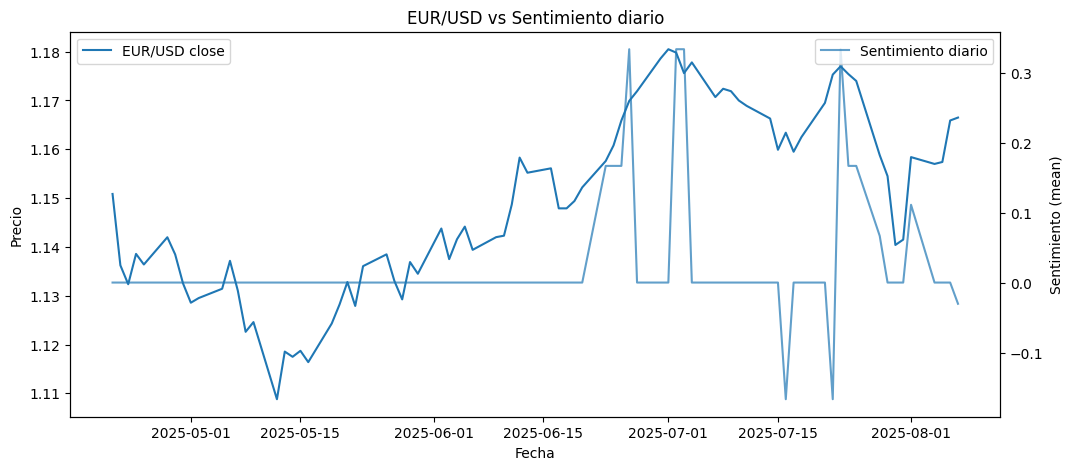

In [18]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(df.index, df["close"], label="EUR/USD close")
ax1.set_xlabel("Fecha"); ax1.set_ylabel("Precio")

ax2 = ax1.twinx()
ax2.plot(df.index, df["sent_mean"], alpha=0.7, label="Sentimiento diario")
ax2.set_ylabel("Sentimiento (mean)")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("EUR/USD vs Sentimiento diario")
plt.show()


La gráfica muestra la evolución del precio de cierre del EUR/USD (línea azul izquierda) junto al promedio diario de sentimiento (línea azul derecha) para el mismo periodo.

El eje izquierdo indica el precio del EUR/USD.
El eje derecho indica el valor del sentimiento diario (positivo o negativo).

**Interpretación**:
Se puede ver cómo varía el precio y el sentimiento cada día. Si ambas líneas suben o bajan juntas, podría haber cierta relación entre el sentimiento de las noticias y el movimiento del precio.
En este caso, el sentimiento tiene cambios bruscos y no parece seguir claramente la tendencia del precio, lo que sugiere que no hay una correlación fuerte entre ambos en este periodo.